### Load packages
Import Python packages that are used for the analysis.

In [1]:
from pystac_client import Client
from odc.stac import load
from planetary_computer import sign_url

from scipy.ndimage import uniform_filter, variance
from skimage.filters import threshold_minimum

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipyleaflet import basemaps, basemap_to_tiles
from odc.ui import select_on_a_map

import odc.geo.xr  # noqa: F401

## Find and load data

In this example, we're using Sentinel-1 radiometrically terrain corrected
data from the Microsoft Planetary Computer. This is freely available, but
you need to use a special Python function `sign_url` to authorise access.

In [2]:
# Microsoft Planetary Computer STAC Catalog URL
catalog = "https://planetarycomputer.microsoft.com/api/stac/v1"

# Create a STAC Client
client = Client.open(catalog)

In [3]:
# Set study area name for outputs
study_area = "se-asia"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(12, 120), zoom=4)
#geom

Map(center=[12, 120], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [12]:
datetime = "2024-01/2024-12"

items = client.search(
    collections=["sentinel-1-rtc"],
    intersects=geom,
    datetime=datetime,
).item_collection()

print(f"Found {len(items)} items")

Found 51 items


In [13]:
data = load(
    items,
    geopolygon=geom,
    measurements=["vv", "vh"],
    groupby="solar_day",
    patch_url=sign_url,
    chunks={"x": 2048, "y": 2048}
).compute()

data

<xarray.Dataset> Size: 33MB
Dimensions:      (y: 268, x: 302, time: 51)
Coordinates:
  * y            (y) float64 2kB 8.06e+06 8.06e+06 ... 8.058e+06 8.057e+06
  * x            (x) float64 2kB 5.706e+05 5.706e+05 ... 5.736e+05 5.736e+05
    spatial_ref  int32 4B 32760
  * time         (time) datetime64[ns] 408B 2024-01-08T06:40:46.659976 ... 20...
Data variables:
    vv           (time, y, x) float32 17MB 0.2039 0.19 ... 0.09622 0.1275
    vh           (time, y, x) float32 17MB 0.05564 0.0492 ... 0.07312 0.04535

### Plot data

Do some simple plots of the data, so we know what we're working with

In [14]:
# Plot VV polarisation
#data.isel(time=range(0,27)).vv.plot(cmap="Greys_r", robust=True, col="time", col_wrap=3);

In [15]:
# Plot VH polarisation
#data.isel(time=range(0,12)).vh.plot(cmap="Greys_r", robust=True, col="time", col_wrap=3);

#### Plot VV polarisation

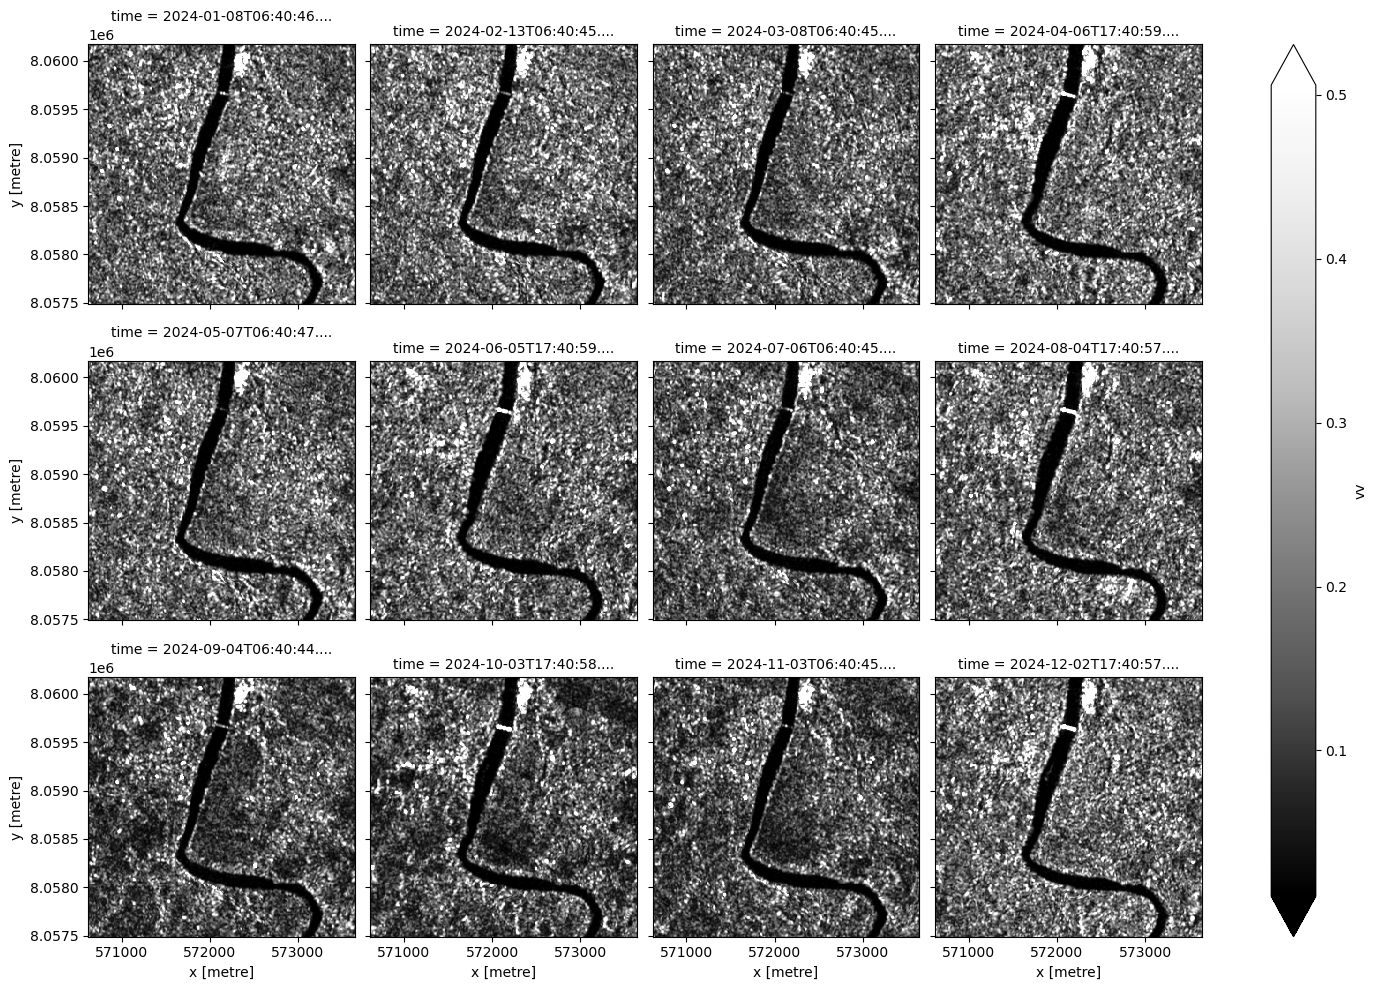

In [16]:
# Convert the time coordinate to pandas datetime
times = pd.to_datetime(data.time.values)

# Convert to monthly periods and get the first index of each unique month
_, unique_month_indices = np.unique(times.to_period("M"), return_index=True)

# Select only one image per month
monthly_data = data.isel(time=unique_month_indices)

# Plot VV polarization (1 image per month)
monthly_data.vv.plot(
    cmap="Greys_r",
    robust=True,
    col="time",
    col_wrap=4,
    figsize=(15, 10)
)


#### Plot VH polarisation

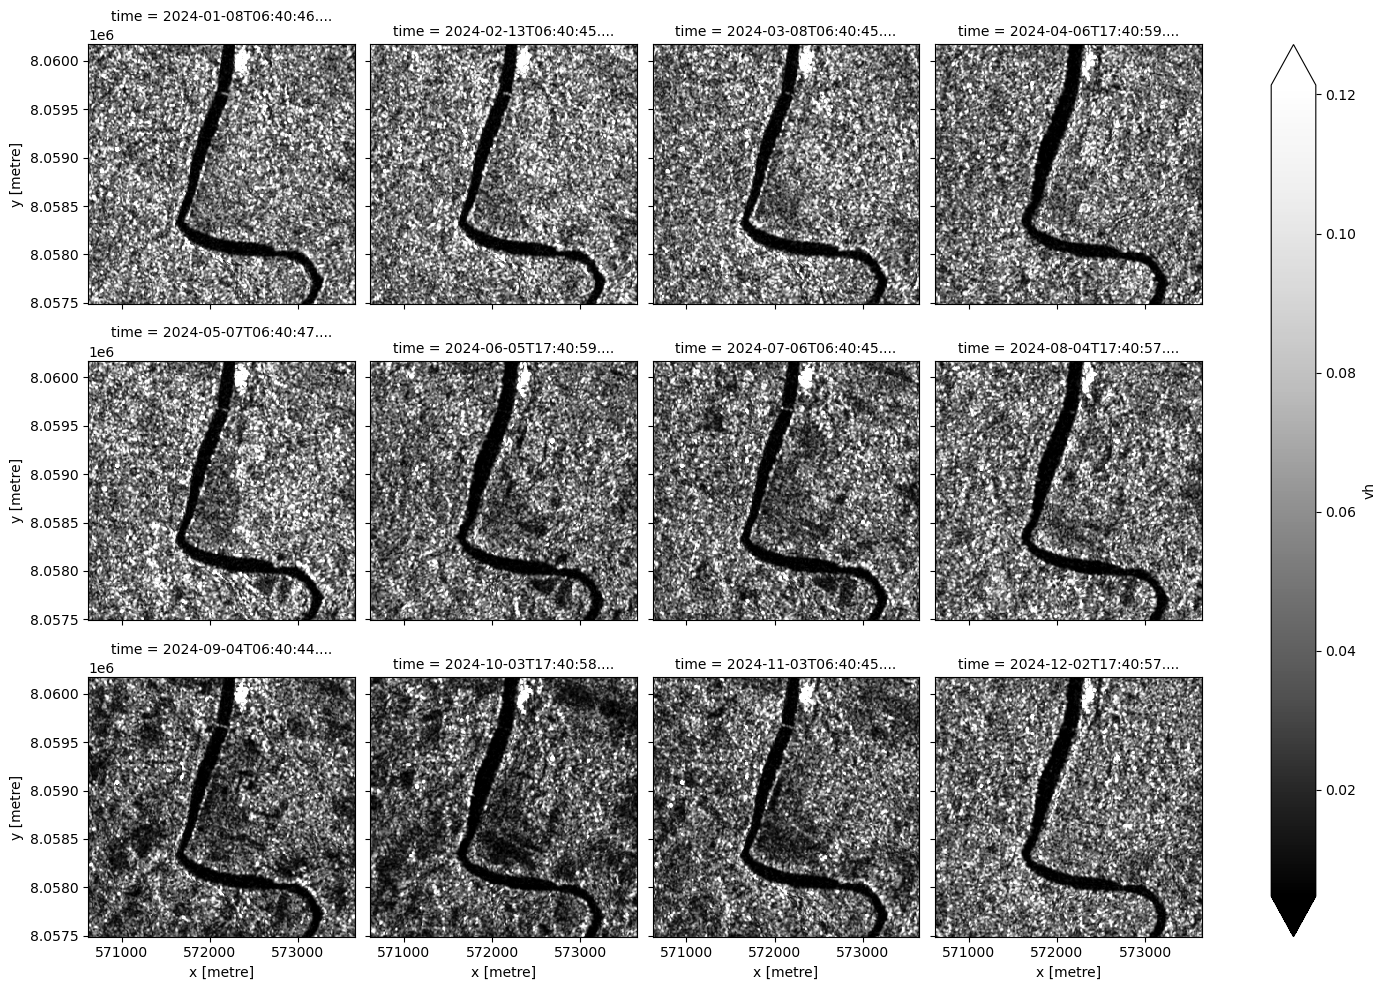

In [17]:
# Convert the time coordinate to pandas datetime
times = pd.to_datetime(data.time.values)

# Convert to monthly periods and get the first index of each unique month
_, unique_month_indices = np.unique(times.to_period("M"), return_index=True)

# Select only one image per month
monthly_data = data.isel(time=unique_month_indices)

# Plot VV polarization (1 image per month)
monthly_data.vh.plot(
    cmap="Greys_r",
    robust=True,
    col="time",
    col_wrap=4,
    figsize=(15, 10)
)


Backscatter measurements can be combined in visualization to highlight the different polarization signatures. 
For the RGB visualization below, the ratio between VH and VV is added as a third measurement band.

In [10]:
# Get monthly indices
times = pd.to_datetime(data.time.values)
_, unique_month_indices = np.unique(times.to_period("M"), return_index=True)

In [19]:
# # Because this VV/VH data is coming from the MPC stac catalogue and the RTC collection, it has already been scaled and offset so we do not need to do that again. 

# # Select those time steps from scaled data
# monthly_scaled = scaled.isel(time=unique_month_indices)

monthly_data

<xarray.Dataset> Size: 8MB
Dimensions:      (y: 268, x: 302, time: 12)
Coordinates:
  * y            (y) float64 2kB 8.06e+06 8.06e+06 ... 8.058e+06 8.057e+06
  * x            (x) float64 2kB 5.706e+05 5.706e+05 ... 5.736e+05 5.736e+05
    spatial_ref  int32 4B 32760
  * time         (time) datetime64[ns] 96B 2024-01-08T06:40:46.659976 ... 202...
Data variables:
    vv           (time, y, x) float32 4MB 0.2039 0.19 0.09764 ... 0.3934 0.1732
    vh           (time, y, x) float32 4MB 0.05564 0.0492 ... 0.08594 0.06348

In [28]:
monthly_data["vv_vh"] = monthly_data["vv"]/monthly_data["vh"]

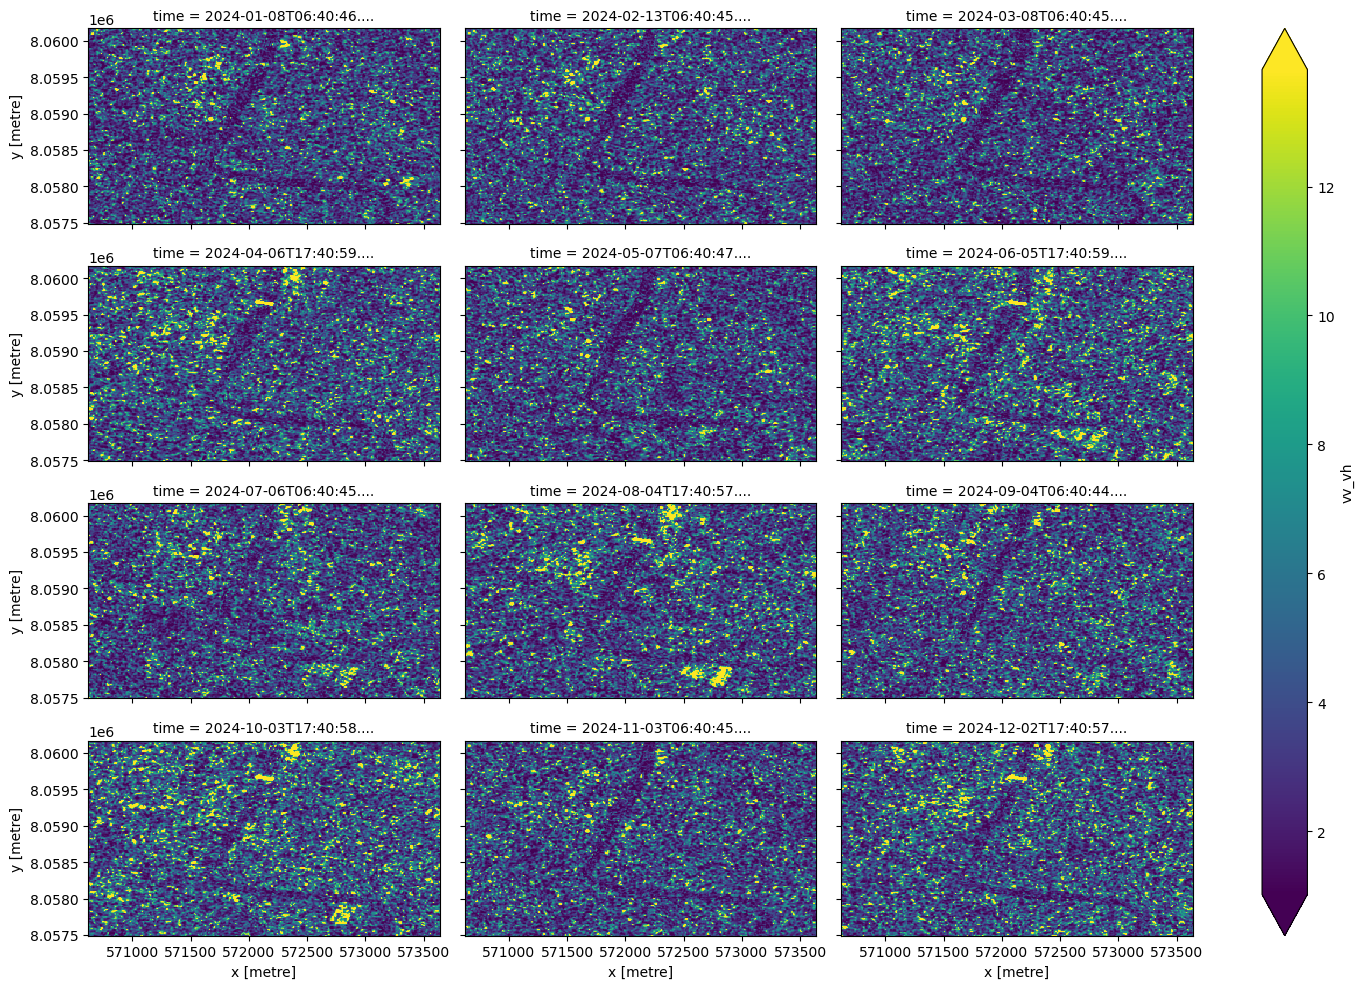

In [30]:
# Plot scaled VH, VV, and VH/VV as RGB
monthly_data.vv_vh.plot.imshow(
    robust=True,
    col="time",
    col_wrap=3,
    figsize=(15, 10)
)

## Apply speckle filtering

Radar observations appear speckly due to random interference of coherent signals from target scatters. 
The speckle noise can be reduced by averaging pixel values over an area or over time. 
However, averaging over a fixed window smoothes out real local spatial variation and leads to reduced spatial resolution.
An adaptive approach that takes into account local homogeneity is therefore preferred.

Below, we apply the Lee filter, one of the popular adaptive speckle filters.


In [ ]:
# Define a function to apply lee filtering on S1 image 
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    da_notime = da.squeeze()
    img = da_notime.values
    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img**2, size)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    # Convert numpy array back to xarray, flipping the Y axis
    output = xr.DataArray(img_output, dims=da_notime.dims, coords=da_notime.coords)
    
    return output

# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = np.isfinite(data)
masked = data.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
data["filtered_vv"] = masked.vv.groupby("time").map(lee_filter, size=7)
data["filtered_vh"] = masked.vh.groupby("time").map(lee_filter, size=7)

# Null pixels should remain null
data['filtered_vv'] = data.filtered_vv.where(valid.vv)
data['filtered_vh'] = data.filtered_vh.where(valid.vh)

In [ ]:
# Images appear smoother after speckle filtering
fig, ax = plt.subplots(1, 2, figsize=(15,5))
data["vv"].isel(time=3).plot(ax = ax[0],robust=True)
data["filtered_vv"].isel(time=3).plot(ax = ax[1],robust=True);
ax[0].set_title('vv')
ax[1].set_title('filtered vv')
plt.tight_layout();

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

# Define Lee filter function
def lee_filter(da, size):
    """
    Apply Lee speckle filter with specified window size.
    Adapted from: https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
    """
    da_notime = da.squeeze()
    img = da_notime.values.astype(np.float32)

    img_mean = uniform_filter(img, size)
    img_sqr_mean = uniform_filter(img**2, size)
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = np.var(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    # Convert numpy array back to xarray
    output = xr.DataArray(
        img_output,
        dims=da_notime.dims,
        coords=da_notime.coords,
        attrs=da_notime.attrs
    )

    return output

# Handle nulls: Replace NaNs with 0 for filtering
masked = data.copy()
masked["vv"] = xr.DataArray(np.nan_to_num(data.vv), dims=data.vv.dims, coords=data.vv.coords)
masked["vh"] = xr.DataArray(np.nan_to_num(data.vh), dims=data.vh.dims, coords=data.vh.coords)

# Apply Lee filter per time step
data["filtered_vv"] = masked.vv.groupby("time").map(lee_filter, size=7)
data["filtered_vh"] = masked.vh.groupby("time").map(lee_filter, size=7)

# Restore original NaN values
data["filtered_vv"] = data["filtered_vv"].where(np.isfinite(data.vv))
data["filtered_vh"] = data["filtered_vh"].where(np.isfinite(data.vh))

# ✅ Visualize original vs filtered for a specific time
t_idx = 3
date_str = str(data.time.values[t_idx])[:10]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
data["vv"].isel(time=t_idx).plot(ax=ax[0], robust=True)
data["filtered_vv"].isel(time=t_idx).plot(ax=ax[1], robust=True)

ax[0].set_title(f'Original VV ({date_str})')
ax[1].set_title(f'Filtered VV ({date_str})')
plt.tight_layout()
plt.show()
